In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


True
1
Tesla T4
Device: cuda


In [9]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.labels = df['label'].values
        self.images = df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx] / 255.0
        label = self.labels[idx]
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        return image_tensor, label

train_dataset = SignLanguageDataset('sign_mnist_train.csv')
test_dataset = SignLanguageDataset('sign_mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 25)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)

model = SimpleNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=1e-4
)

In [11]:
epochs = 30

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / len(test_dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Epoch 1/30 | Train Loss: 2.5458, Train Acc: 0.2090 | Test Loss: 1.8766, Test Acc: 0.4239
Epoch 2/30 | Train Loss: 1.6847, Train Acc: 0.4435 | Test Loss: 1.4821, Test Acc: 0.5158
Epoch 3/30 | Train Loss: 1.3497, Train Acc: 0.5482 | Test Loss: 1.2478, Test Acc: 0.6004
Epoch 4/30 | Train Loss: 1.1148, Train Acc: 0.6214 | Test Loss: 1.1761, Test Acc: 0.6189
Epoch 5/30 | Train Loss: 0.9390, Train Acc: 0.6822 | Test Loss: 1.0150, Test Acc: 0.6744
Epoch 6/30 | Train Loss: 0.7830, Train Acc: 0.7342 | Test Loss: 0.9340, Test Acc: 0.6926
Epoch 7/30 | Train Loss: 0.6820, Train Acc: 0.7699 | Test Loss: 0.8939, Test Acc: 0.7124
Epoch 8/30 | Train Loss: 0.5900, Train Acc: 0.8012 | Test Loss: 0.8925, Test Acc: 0.7076
Epoch 9/30 | Train Loss: 0.5133, Train Acc: 0.8236 | Test Loss: 0.8301, Test Acc: 0.7347
Epoch 10/30 | Train Loss: 0.4489, Train Acc: 0.8474 | Test Loss: 0.8171, Test Acc: 0.7421
Epoch 11/30 | Train Loss: 0.4002, Train Acc: 0.8662 | Test Loss: 0.7850, Test Acc: 0.7593
Epoch 12/30 | Train

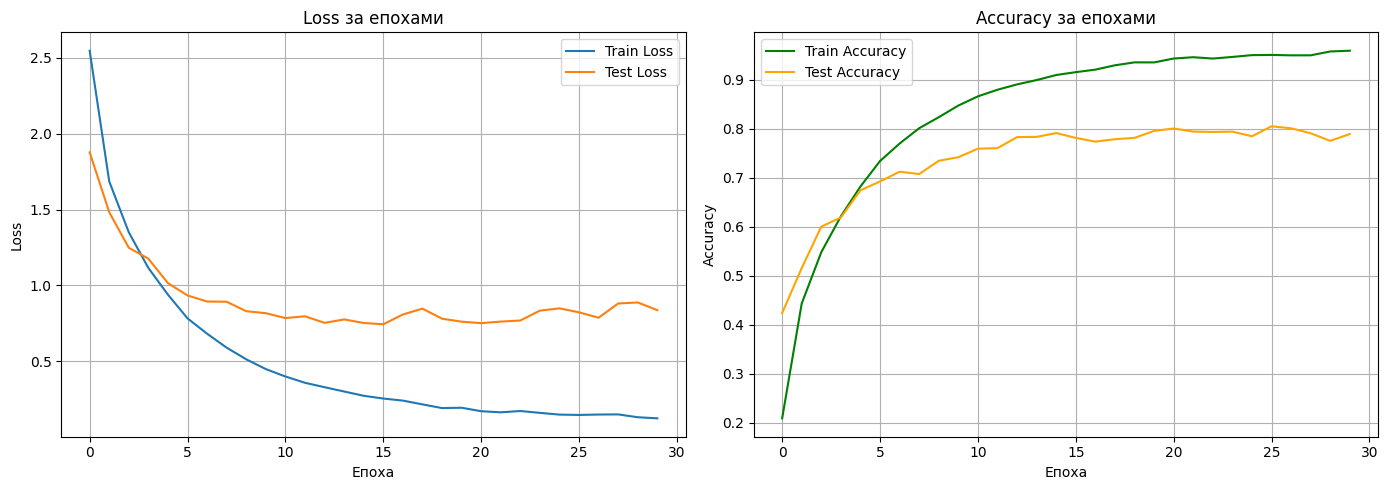

In [12]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss за епохами")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.plot(test_accuracies, label="Test Accuracy", color="orange")
plt.title("Accuracy за епохами")
plt.xlabel("Епоха")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

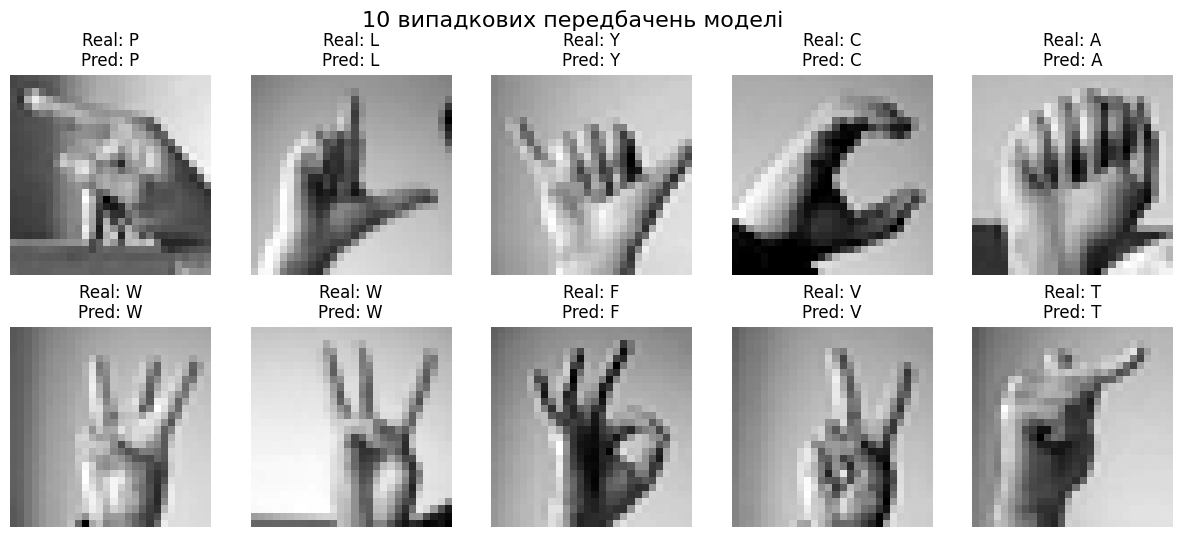

In [13]:
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax in axes:
    idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[idx]
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred_label = output.argmax(1).item()

    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Real: {chr(true_label + 65)}\nPred: {chr(pred_label + 65)}")
    ax.axis("off")

plt.suptitle("10 випадкових передбачень моделі", fontsize=16)
plt.show()
